`import libraries`

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from lifelines import KaplanMeierFitter
import kagglehub

`load dataset`

In [30]:
path = kagglehub.dataset_download("sergeymedvedev/customer_segmentation")
print("Dataset download path:", path)

data = pd.read_csv(os.path.join(path, "customer_segmentation.csv"), encoding="cp1252")
print("Dataset loaded successfully.")

Dataset download path: C:\Users\ravin\.cache\kagglehub\datasets\sergeymedvedev\customer_segmentation\versions\1
Dataset loaded successfully.


In [31]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [33]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


`cleaning and transformation`

In [34]:
data = data.dropna(subset=["CustomerID"])
data = data[(data["Quantity"] > 0) & (data["UnitPrice"] > 0)]
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Revenue"] = data["UnitPrice"] * data["Quantity"]

In [35]:
customer_data = data.groupby("CustomerID").agg(
    {
        "InvoiceDate": ["min", "max", "nunique"],
        "Revenue": "sum",
    }
).reset_index()

customer_data.columns = [
    "CustomerID",
    "FirstPurchaseDate",
    "LastPurchaseDate",
    "Frequency",
    "TotalRevenue",
]

customer_data["RetentionDuration"] = (customer_data["LastPurchaseDate"] - customer_data["FirstPurchaseDate"]
).dt.days
customer_data["Recency"] = (data["InvoiceDate"].max() - customer_data["LastPurchaseDate"]
).dt.days

In [36]:
customer_data["LogTotalRevenue"] = np.log1p(customer_data["TotalRevenue"])
customer_data["LogRetentionDuration"] = np.log1p(customer_data["RetentionDuration"])

In [37]:
print(customer_data.isnull().sum())
print(np.isinf(customer_data).sum())

CustomerID              0
FirstPurchaseDate       0
LastPurchaseDate        0
Frequency               0
TotalRevenue            0
RetentionDuration       0
Recency                 0
LogTotalRevenue         0
LogRetentionDuration    0
dtype: int64
CustomerID              0
FirstPurchaseDate       0
LastPurchaseDate        0
Frequency               0
TotalRevenue            0
RetentionDuration       0
Recency                 0
LogTotalRevenue         0
LogRetentionDuration    0
dtype: int64


In [40]:
customer_data.head()

,CustomerID,FirstPurchaseDate,LastPurchaseDate,Frequency,TotalRevenue,RetentionDuration,Recency,LogTotalRevenue,LogRetentionDuration
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,0,325,11.253955,0.000000
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,7,4310.00,365,1,8.368925,5.902633
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,4,1797.24,282,74,7.494564,5.645447
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,1,1757.55,0,18,7.472245,0.000000
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,1,334.40,0,309,5.815324,0.000000


In [41]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerID            4338 non-null   float64       
 1   FirstPurchaseDate     4338 non-null   datetime64[ns]
 2   LastPurchaseDate      4338 non-null   datetime64[ns]
 3   Frequency             4338 non-null   int64         
 4   TotalRevenue          4338 non-null   float64       
 5   RetentionDuration     4338 non-null   int64         
 6   Recency               4338 non-null   int64         
 7   LogTotalRevenue       4338 non-null   float64       
 8   LogRetentionDuration  4338 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 305.1 KB


In [42]:
customer_data.describe()

,CustomerID,FirstPurchaseDate,LastPurchaseDate,Frequency,TotalRevenue,RetentionDuration,Recency,LogTotalRevenue,LogRetentionDuration
count,4338.000000,4338,4338,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,2011-04-30 17:06:50.857538048,2011-09-08 11:38:59.045643008,4.250807,2054.266460,130.448594,91.536422,6.593627,3.242536
min,12346.000000,2010-12-01 08:26:00,2010-12-01 09:53:00,1.000000,3.750000,0.000000,0.000000,1.558145,0.000000
25%,13813.250000,2011-01-17 11:13:15,2011-07-20 19:18:00,1.000000,307.415000,0.000000,17.000000,5.731446,0.000000
50%,15299.500000,2011-04-05 09:52:30,2011-10-20 10:40:30,2.000000,674.485000,92.500000,50.000000,6.515431,4.537947
75%,16778.750000,2011-08-19 10:11:30,2011-11-22 11:05:45,5.000000,1661.740000,251.750000,141.000000,7.416222,5.532399
max,18287.000000,2011-12-09 12:16:00,2011-12-09 12:50:00,210.000000,280206.020000,373.000000,373.000000,12.543284,5.924256
std,1721.808492,NaN,NaN,7.635202,8989.230441,132.039554,100.014169,1.257578,2.527555


`exploratory data analysis (EDA)`

Text(0, 0.5, 'Frequency')

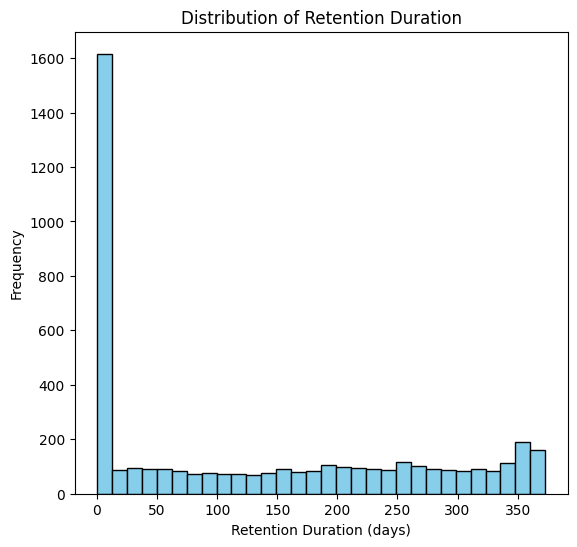

In [43]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(customer_data["RetentionDuration"],bins=30, edgecolor="k", color="skyblue")
plt.title("Distribution of Retention Duration")
plt.xlabel("Retention Duration (days)")
plt.ylabel("Frequency")

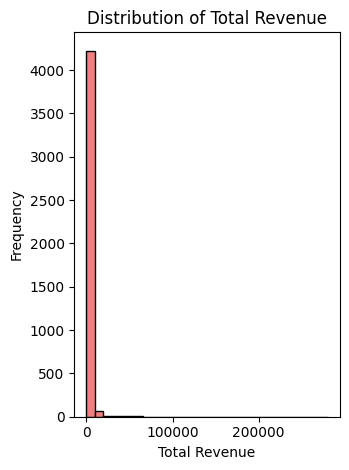

In [44]:
plt.subplot(1, 2, 2)
plt.hist(customer_data["TotalRevenue"], bins=30,edgecolor="k", color="lightcoral")
plt.title("Distribution of Total Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

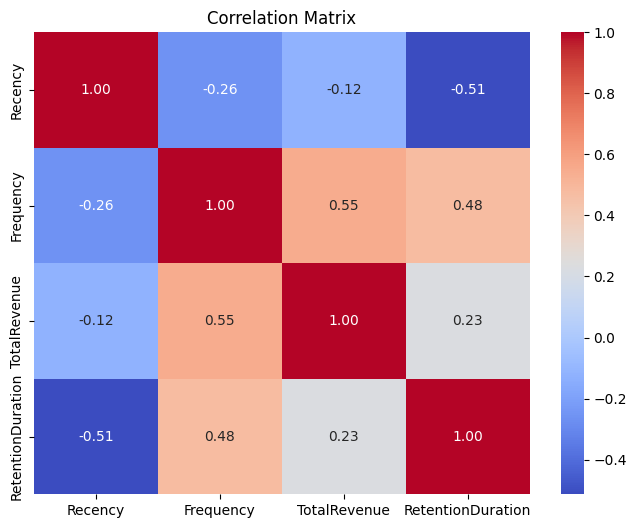

In [45]:
correlation_matrix = customer_data[["Recency", "Frequency", "TotalRevenue", "RetentionDuration"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

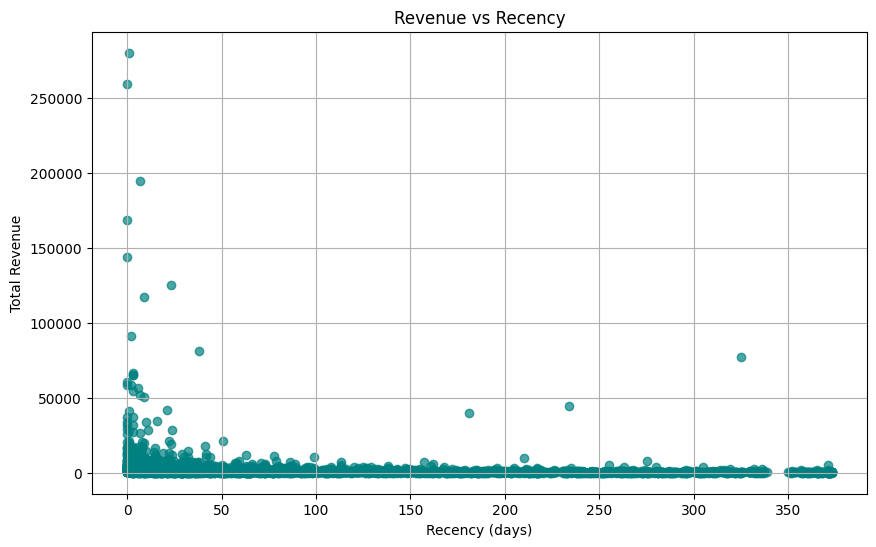

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(customer_data["Recency"],customer_data["TotalRevenue"], alpha=0.7, color="teal")
plt.title("Revenue vs Recency")
plt.xlabel("Recency (days)")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

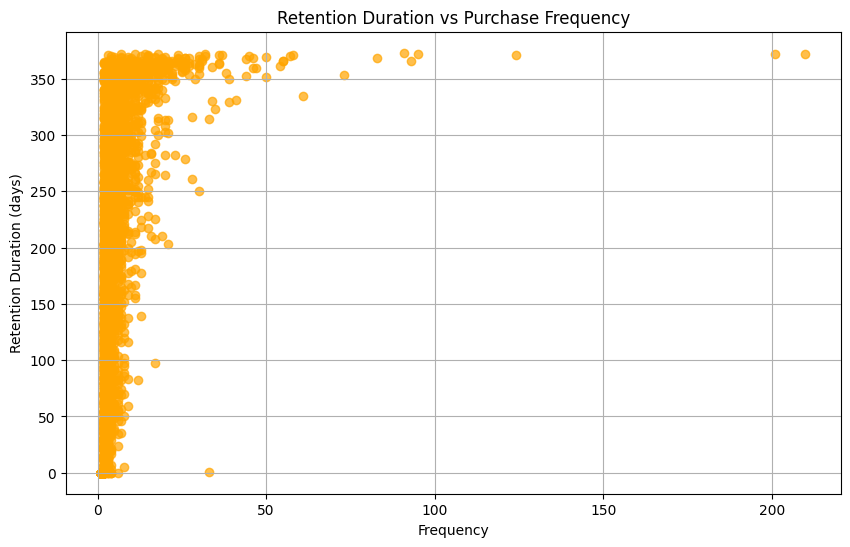

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(customer_data["Frequency"],customer_data["RetentionDuration"], alpha=0.7, color="orange")
plt.title("Retention Duration vs Purchase Frequency")
plt.xlabel("Frequency")
plt.ylabel("Retention Duration (days)")
plt.grid(True)
plt.show()

`preprocessing`

In [48]:
X_retention = customer_data[["Recency", "Frequency", "LogTotalRevenue"]]
y_retention = customer_data["LogRetentionDuration"]

X_clv = customer_data[["Recency", "Frequency", "LogTotalRevenue", "LogRetentionDuration"]]
y_clv = customer_data["LogTotalRevenue"]

In [49]:
scaler_retention = StandardScaler()
X_retention_scaled = scaler_retention.fit_transform(X_retention)

scaler_clv = StandardScaler()
X_clv_scaled = scaler_clv.fit_transform(X_clv)

In [50]:
X_train_ret, X_test_ret, y_train_ret, y_test_ret = train_test_split(X_retention_scaled, y_retention, test_size=0.2, random_state=42)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv_scaled, y_clv, test_size=0.2, random_state=42)

`cross-validation for retention model`

In [51]:
param_grid_ret = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

ts_cv = TimeSeriesSplit(n_splits=5)
retention_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search_ret = GridSearchCV(
    estimator=retention_model,
    param_grid=param_grid_ret,
    scoring="r2",
    cv=ts_cv,
    verbose=1,
    n_jobs=-1
)
grid_search_ret.fit(X_train_ret, y_train_ret)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [52]:
best_retention_model = grid_search_ret.best_estimator_
print("Best Parameters for Retention Model:", grid_search_ret.best_params_)

Best Parameters for Retention Model: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'subsample': 0.8}


In [53]:
cv_scores_retention = cross_val_score(best_retention_model, X_retention_scaled, y_retention, cv=5, scoring="r2", n_jobs=-1)

print("Retention Model Cross-Validation R2 Scores:", cv_scores_retention)
print("Retention Model Mean R2 Score:", np.mean(cv_scores_retention))

Retention Model Cross-Validation R2 Scores: [0.93552169 0.92549685 0.91629099 0.89514856 0.88860276]
Retention Model Mean R2 Score: 0.9122121688412275


In [54]:
y_pred_ret = best_retention_model.predict(X_test_ret)
print("Retention Model RMSE:", np.sqrt(mean_squared_error(y_test_ret, y_pred_ret)))
print("Retention Model R2:", r2_score(y_test_ret, y_pred_ret))

Retention Model RMSE: 0.7564274923266828
Retention Model R2: 0.9084396686339425


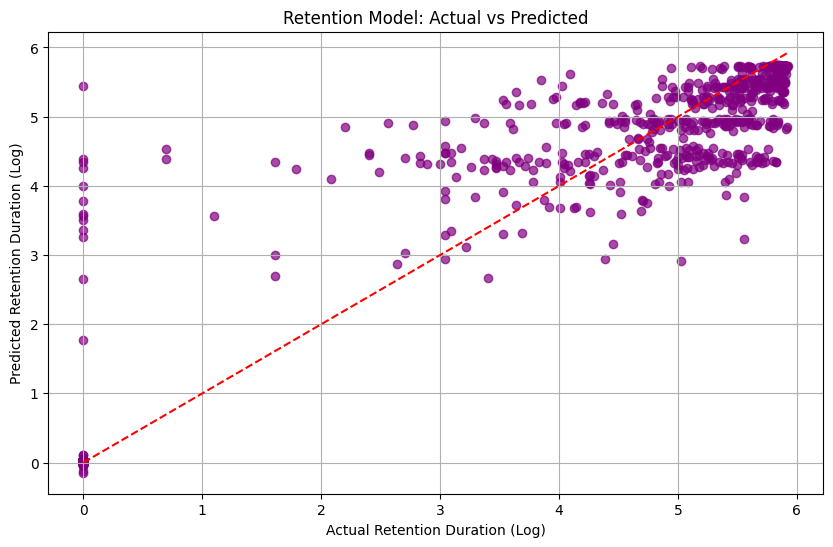

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_ret, y_pred_ret, alpha=0.7, color="purple")
plt.title("Retention Model: Actual vs Predicted")
plt.xlabel("Actual Retention Duration (Log)")
plt.ylabel("Predicted Retention Duration (Log)")
plt.plot([min(y_test_ret), max(y_test_ret)], [min(y_test_ret), max(y_test_ret)], color="red", linestyle="--")
plt.grid(True)
plt.show()

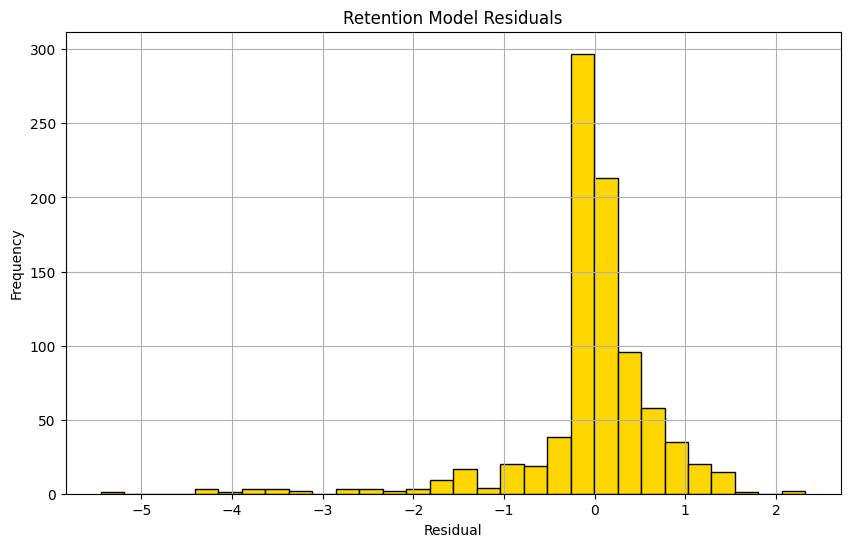

In [56]:
residuals_ret = y_test_ret - y_pred_ret
plt.figure(figsize=(10, 6))
plt.hist(residuals_ret, bins=30, edgecolor="k", color="gold")
plt.title("Retention Model Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

`cross-validation for CLV model`

In [57]:
param_grid_clv = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

clv_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search_clv = GridSearchCV(
    estimator=clv_model,
    param_grid=param_grid_clv,
    scoring="r2",
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search_clv.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [58]:
best_clv_model = grid_search_clv.best_estimator_
print("Best Parameters for CLV Model:", grid_search_clv.best_params_)

Best Parameters for CLV Model: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}


In [59]:
cv_scores_clv = cross_val_score(best_clv_model, X_clv_scaled, y_clv, cv=5, scoring="r2", n_jobs=-1)

print("CLV Model Cross-Validation R2 Scores:", cv_scores_clv)
print("CLV Model Mean R2 Score:", np.mean(cv_scores_clv))

CLV Model Cross-Validation R2 Scores: [0.9988334  0.99854111 0.99773091 0.99569658 0.99758291]
CLV Model Mean R2 Score: 0.9976769820925309


In [60]:
y_pred_clv = best_clv_model.predict(X_test_clv)
print("CLV Model RMSE:", np.sqrt(mean_squared_error(y_test_clv, y_pred_clv)))
print("CLV Model R2:", r2_score(y_test_clv, y_pred_clv))

CLV Model RMSE: 0.05889287902492758
CLV Model R2: 0.9978365841913267


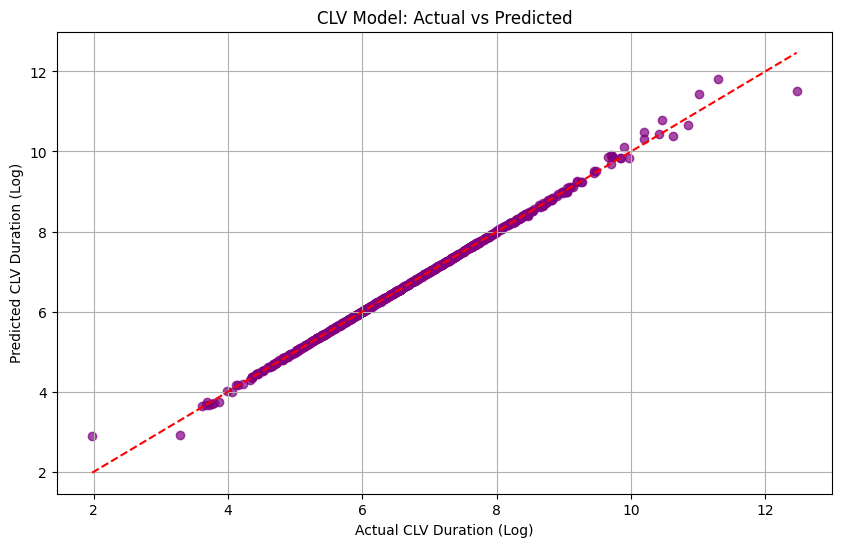

In [61]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_clv, y_pred_clv, alpha=0.7, color="purple")
plt.title("CLV Model: Actual vs Predicted")
plt.xlabel("Actual CLV Duration (Log)")
plt.ylabel("Predicted CLV Duration (Log)")
plt.plot([min(y_test_clv), max(y_test_clv)], [min(y_test_clv), max(y_test_clv)], color="red", linestyle="--")
plt.grid(True)
plt.show()

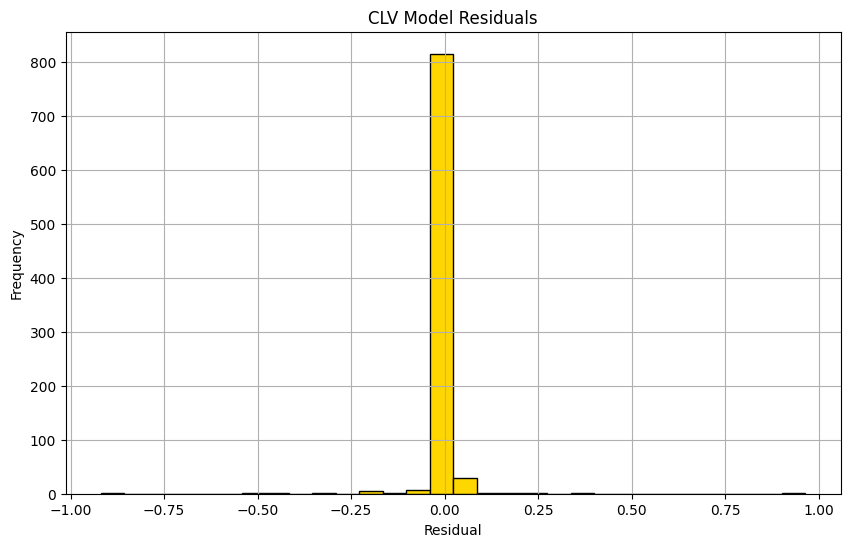

In [62]:
residuals_clv = y_test_clv - y_pred_clv
plt.figure(figsize=(10, 6))
plt.hist(residuals_clv, bins=30, edgecolor="k", color="gold")
plt.title("CLV Model Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

`testing functions`

In [63]:
def predict_customer_retention_and_clv(customer_id):
    customer = customer_data[customer_data["CustomerID"] == customer_id].copy()

    if customer.empty:
        print(f"Customer ID {customer_id} not found.")
        return

    # Predict Retention Duration
    features_ret = scaler_retention.transform(customer[["Recency", "Frequency", "LogTotalRevenue"]])
    predicted_retention = np.expm1(best_retention_model.predict(features_ret)[0])

    # Predict CLV
    customer.loc[:, "LogRetentionDuration"] = np.log1p(predicted_retention)
    features_clv = scaler_clv.transform(customer[["Recency", "Frequency", "LogTotalRevenue", "LogRetentionDuration"]])
    predicted_clv = np.expm1(best_clv_model.predict(features_clv)[0])

    print("-" * 50)
    print(f"Customer ID: {customer_id}\n")
    print("Predicted Data:")
    print(f"\tPredicted Retention Duration: {predicted_retention:.2f} days")
    print(f"\tPredicted CLV: {predicted_clv:.2f}")

In [64]:
def visualize_customer_activity(customer_id):
    customer = data[data["CustomerID"] == customer_id].copy()

    if customer.empty:
        print(f"Customer ID {customer_id} not found.")
        return

    customer["CumulativeRevenue"] = customer["Revenue"].cumsum()
    total_revenue = customer["Revenue"].sum()
    total_days = (customer["InvoiceDate"].max() - customer["InvoiceDate"].min()).days

    print("Historical Data :")
    print(f"\tTotal Days Spent with Service: {total_days} days")
    print(f"\tTotal Revenue Generated: {total_revenue:.2f}")
    print("-" * 50)

    plt.figure(figsize=(12, 6))
    plt.plot(customer["InvoiceDate"], customer["CumulativeRevenue"], marker="o", linestyle="-", color="blue")
    plt.title(f"Customer {customer_id} - Activity Timeline")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Revenue")
    plt.grid(True)
    plt.show()

`customer retention survival curve`

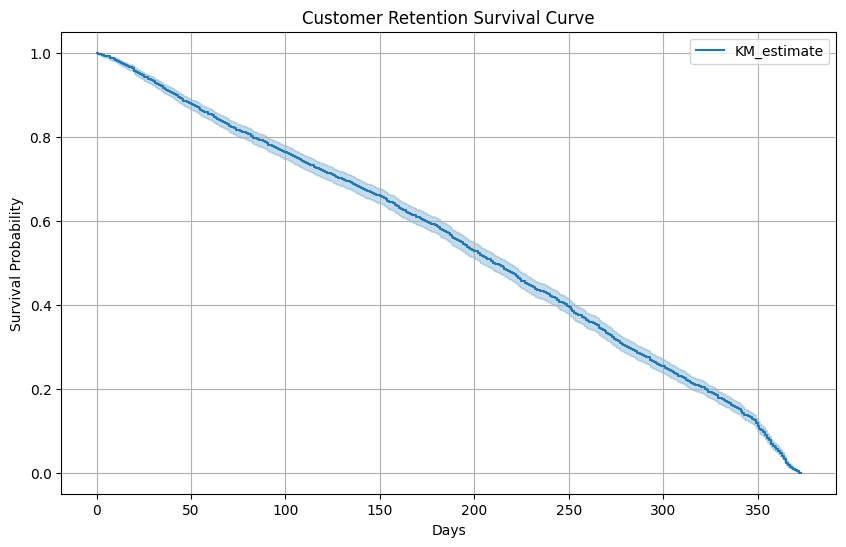

In [65]:
kmf = KaplanMeierFitter()
kmf.fit(
    durations=customer_data["RetentionDuration"],
    event_observed=(customer_data["RetentionDuration"] > customer_data["RetentionDuration"].quantile(0.01))
)

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("Customer Retention Survival Curve")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

`testing`

--------------------------------------------------
Customer ID: 16910

Predicted Data:
	Predicted Retention Duration: 241.60 days
	Predicted CLV: 1518.35
Historical Data :
	Total Days Spent with Service: 86 days
	Total Revenue Generated: 1510.06
--------------------------------------------------


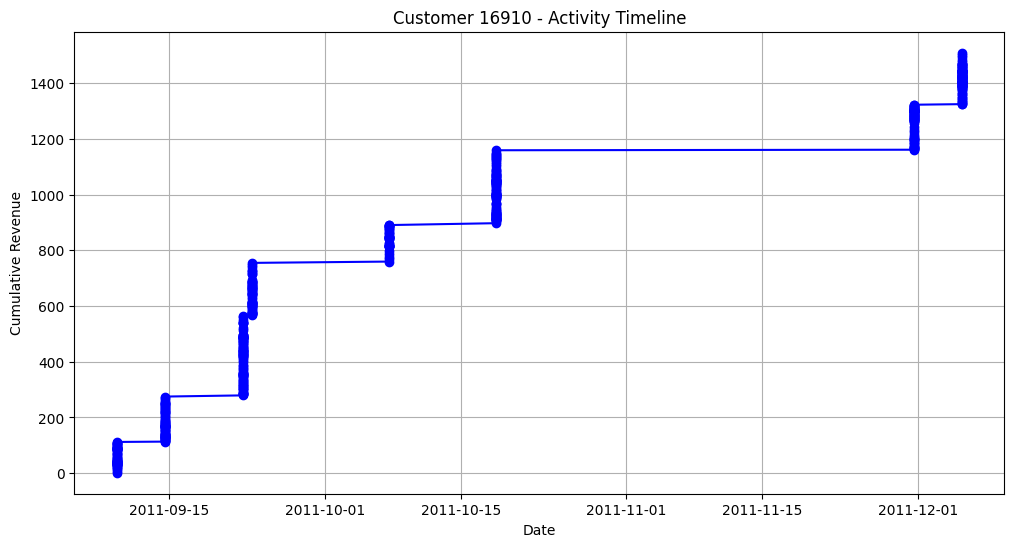

In [66]:
customer = 16910  # 16053 17997 16910
predict_customer_retention_and_clv(customer)
visualize_customer_activity(customer)